<a href="https://www.kaggle.com/code/inzeyun/notebook4407d644ef?scriptVersionId=168497533" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Time to Event (ToE)
* Trial details: https://classic.clinicaltrials.gov/ct2/show/record/NCT00000625

In [22]:
import numpy as np
import pandas as pd
import scipy.stats

from sklearn.model_selection import ShuffleSplit
import xgboost as xgb

In [23]:
data=pd.read_csv("/kaggle/input/aids-clinical-trials/AIDS_ClinicalTrial_GroupStudy175.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 24 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   time     2139 non-null   int64  
 1   trt      2139 non-null   int64  
 2   age      2139 non-null   int64  
 3   wtkg     2139 non-null   float64
 4   hemo     2139 non-null   int64  
 5   homo     2139 non-null   int64  
 6   drugs    2139 non-null   int64  
 7   karnof   2139 non-null   int64  
 8   oprior   2139 non-null   int64  
 9   z30      2139 non-null   int64  
 10  zprior   2139 non-null   int64  
 11  preanti  2139 non-null   int64  
 12  race     2139 non-null   int64  
 13  gender   2139 non-null   int64  
 14  str2     2139 non-null   int64  
 15  strat    2139 non-null   int64  
 16  symptom  2139 non-null   int64  
 17  treat    2139 non-null   int64  
 18  offtrt   2139 non-null   int64  
 19  cd40     2139 non-null   int64  
 20  cd420    2139 non-null   int64  
 21  cd80     2139 

In [24]:
data.time.agg(["mean","median","min","max","std"]).to_frame().T.round(2)

,mean,median,min,max,std
time,879.1,997.0,14.0,1231.0,292.27


<Axes: xlabel='Cell Count Diff.'>

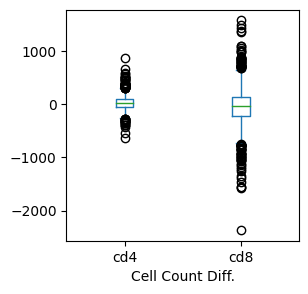

In [25]:
data["cd4"]=data.cd420-data.cd40
data["cd8"]=data.cd820-data.cd80
data.loc[:,["cd4","cd8"]].plot.box(figsize=(3,3),xlabel="Cell Count Diff.")

In [26]:
byLabel=data.loc[:,["label","cd4","cd8"]]

byLabelCd4=scipy.stats.ttest_ind(
    byLabel.query("label==0").cd4,
    byLabel.query("label==1").cd4,
)

byLabelCd8=scipy.stats.ttest_ind(
    byLabel.query("label==0").cd8,
    byLabel.query("label==1").cd8,
)

print(data.groupby("label")[["cd4","cd8"]].agg("mean").T)
print(
    "CD4 Difference (vs. failure) 95% CI:",
    np.round(byLabelCd4.confidence_interval(),2),
    byLabelCd4.statistic.round(2),
    "p:",
    round(byLabelCd4.pvalue,2)
)
print(
    "CD8 Difference (vs. failure) 95% CI:",
    np.round(byLabelCd8.confidence_interval(),2),
    byLabelCd8.statistic.round(2),
    "p:",
    round(byLabelCd8.pvalue,2)
)

label          0          1
cd4    36.700865 -28.556622
cd8   -38.378863 -91.253359
CD4 Difference (vs. failure) 95% CI: [53.49 77.02] 10.88 p: 0.0
CD8 Difference (vs. failure) 95% CI: [20.87 84.88] 3.24 p: 0.0


In [27]:
byTrt=data.loc[:,["trt","cd4","cd8"]]

byTrtCd4=scipy.stats.ttest_ind(
    byTrt.query("trt==0").cd4,
    byTrt.query("trt==1").cd4,
)

print(data.groupby("trt")[["cd4","cd8"]].agg("mean").T)
print(
    "CD4 Difference (vs. better regimen) 95% CI:",
    np.round(byTrtCd4.confidence_interval(),2),
    "p:",
    round(byTrtCd4.pvalue,2)
)

trt          0          1          2          3
cd4 -17.065789  54.448276  19.263359  26.857398
cd8 -59.035714 -36.340996 -82.492366 -28.586453
CD4 Difference (vs. better regimen) 95% CI: [-86.73 -56.3 ] p: 0.0


In [28]:
byBaseline=data.loc[:,["wtkg","karnof","age","cd4","cd8"]]
byBaseline.corr().round(2)

,wtkg,karnof,age,cd4,cd8
wtkg,1.00,0.03,0.13,-0.01,-0.02
karnof,0.03,1.00,-0.10,0.04,0.01
age,0.13,-0.10,1.00,-0.01,-0.02
cd4,-0.01,0.04,-0.01,1.00,0.47
cd8,-0.02,0.01,-0.02,0.47,1.00


In [29]:
data["survival0"]=data.time.copy()
data["survival1"]=data.apply(lambda q:"inf" if q.at["label"]==0 else q.at["time"],axis=1).rename("survival1")

In [30]:
x=data.drop(["label","time","cd40","cd420","cd80","cd820","survival0","survival1"],axis=1)
y=data[["survival0","survival1"]]
print("Features:",x.shape)

Features: (2139, 20)


In [31]:
splitter=ShuffleSplit(n_splits=10,train_size=.6,random_state=15222330)
trainIdx,testIdx=next(splitter.split(x))

train=xgb.DMatrix(x.values[trainIdx,:])
train.set_float_info("label_lower_bound",y.survival0.values[trainIdx])
train.set_float_info("label_upper_bound",y.survival1.values[trainIdx])

test=xgb.DMatrix(x.values[testIdx,:])
test.set_float_info("label_lower_bound",y.survival0.values[testIdx])
test.set_float_info("label_upper_bound",y.survival1.values[testIdx])

In [32]:
param={
    "objective":"survival:aft",
    "aft_loss_distribution_scale":.8,
    "aft_loss_distribution":"normal",
    "eval_metric":"aft-nloglik",
    "learning_rate":.01,
    "verbosity":0
}

model=xgb.train(
    param,train,
    num_boost_round=5000,
    evals=[(train,"train"),(test,"test")],
    early_stopping_rounds=100,
    verbose_eval=100,
)

result=pd.DataFrame({
    "lower":y.survival0.values,
    "upper":y.survival1.values,
    "prediction":model.predict(xgb.DMatrix(x.values))
})

[0]	train-aft-nloglik:27.59979	test-aft-nloglik:27.58640
[100]	train-aft-nloglik:8.46440	test-aft-nloglik:8.51028
[200]	train-aft-nloglik:3.03919	test-aft-nloglik:3.21325
[300]	train-aft-nloglik:2.10081	test-aft-nloglik:2.38717
[400]	train-aft-nloglik:1.89776	test-aft-nloglik:2.27173
[500]	train-aft-nloglik:1.83552	test-aft-nloglik:2.27545
[549]	train-aft-nloglik:1.82060	test-aft-nloglik:2.28718


In [33]:
tot=pd.concat([x,result],axis=1)
tot.sample(5)

,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,zprior,...,str2,strat,symptom,treat,offtrt,cd4,cd8,lower,upper,prediction
738,2,31,92.3000,0,1,1,100,0,0,1,...,0,1,0,1,0,132,-568,883,883.0,1227.039917
1171,1,32,72.2000,0,1,0,100,0,1,1,...,1,2,0,1,0,9,126,977,inf,2408.057861
1754,0,46,84.8232,0,1,0,100,0,0,1,...,0,1,0,0,0,-347,-543,583,583.0,269.107605
147,2,39,75.7000,0,1,0,100,0,1,1,...,1,2,0,1,1,-148,-240,1023,inf,1270.049927
2135,0,17,102.9672,1,0,0,100,0,1,1,...,1,3,0,0,1,-155,-729,395,inf,1063.076782


In [34]:
tot.groupby(["trt","symptom"]).prediction.mean().to_frame().T

trt                   0                         1                         2  \
symptom               0            1            0            1            0   
prediction  1882.880981  1541.829834  2656.144043  2454.472412  2385.533691   

trt                                3               
symptom               1            0            1  
prediction  2029.444214  2406.227051  1997.830444

* In context of better regimen, trt==1 (ZDV+ddl) is the best
* No symptom prior to the baseline visit is an indicator for longer ToE